In [70]:
'''Task:
Our company is not working efficiently! We spend way too much time
drafting documents and this needs to be fixed! @
For the company, you need to create an Al Agentic System that can
speed up drafting documents, emails, etc. The Al Agentic System
should have Human-Al Collaboration meaning the Human should be
able to able to provide continuous feedback and the Al Agent shoul
stop when the Human is happy with the draft. The system should 
be fast
nd be able to save the drafts.
able to save
'''

'Task:\nOur company is not working efficiently! We spend way too much time\ndrafting documents and this needs to be fixed! @\nFor the company, you need to create an Al Agentic System that can\nspeed up drafting documents, emails, etc. The Al Agentic System\nshould have Human-Al Collaboration meaning the Human should be\nable to able to provide continuous feedback and the Al Agent shoul\nstop when the Human is happy with the draft. The system should \nbe fast\nnd be able to save the drafts.\nable to save\n'

In [71]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [72]:
load_dotenv()

document_content =""

In [73]:
class AgentState(TypedDict):
    
    messages = Annotated[Sequence[BaseMessage],add_messages]

@tool
def update(content:str)-> str:
    
    '''Updates the document with the provided content.'''

    global document_content
    
    document_content= content
    
    return f'document has been updated successfully the updated content is /n {content}'

@tool
def save(filename :str) -> str:
    ''' save the file in txt format'''
    
    global document_content
    if not filename.endswith('.txt'):
        filename=f'{filename}.txt'
    
    try:
        with open(filename,'w') as file:
            file.write(document_content)
        print(f'document has been saved successfully to {filename}')
        return f'document has been saved successfully to {filename}'
            
            
    except Exception as e:
        return f'error occured {str(e)}'
    
tools =[update,save]

In [74]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [81]:
def ourAgent(state: AgentState) -> AgentState:
    
    print("State keys:", state.keys())
    print("State:", state)
    
    # Safe access to messages
    messages = state.get('messages', [])
    print(f"Current messages count: {len(messages)}")
    
    system_prompt = SystemMessage(content=f"""You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is: {document_content}
    """)
    
    if not messages:
        print("No messages - starting conversation")
        welcome_message = AIMessage(content="This is an agent to help you draft documents and save it into a txt file. What would you like to do with the document?")
        return {"messages": [welcome_message]}        
        
    

    # Get user input for ongoing conversation
    user_input = input("What do you want to do with the document? ")
    print(f'User: {user_input}')
    user_msg = HumanMessage(content=user_input)

    # FIX 1: Correct message concatenation
    all_messages = [system_prompt] + messages + [user_msg]
    
    # Get AI response
    result = model.invoke(all_messages)
    
    print(f'AI: {result.content}')
    
    # FIX 2: Correct attribute name (tool_calls not tool_call)
    if hasattr(result, 'tool_calls') and result.tool_calls:
        print(f'USING tools: {[tc["name"] for tc in result.tool_calls]}')  # Fixed: tool_calls
    
    # FIX 3: Return updated messages
    return {"messages": messages + [user_msg, result]}

In [82]:
def should_continue(state:AgentState) -> AgentState:
    
    messages = state['messages']
    
    if not messages:
        return 'continue'
    
    else:
        for message in reversed(messages):
            
            if hasattr(message,'content'):
                content_lower = message.content.lower()
                if('saved' in content_lower and 'document' in content_lower and 'successfully' in content_lower):
                    return 'end'
    
    return 'continue'

In [83]:
graph = StateGraph(AgentState)

graph.add_node('agent',ourAgent)
toolnode= ToolNode(tools=tools)

graph.add_node('tools',toolnode)

graph.set_entry_point('agent')

graph.add_edge('agent','tools')

graph.add_conditional_edges(
    'tools',
    should_continue,
    {
        'continue':'agent',
        'end':END
    }
)

app = graph.compile()

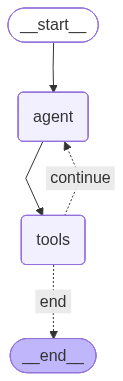

In [84]:
app

In [85]:
def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        print(step)        
        state= step
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()


 ===== DRAFTER =====
{'branch:to:agent': None}
State keys: dict_keys([])
State: {}
Current messages count: 0
No messages - starting conversation
{'branch:to:tools': None}


ValueError: No message found in input